In [2]:
#Imports
import json
import numpy as np
import pandas as pd
import csv
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
def jasonReader(path):
    """ Reads the .jason generated with jasonGenartor the given path"""
    with open(path,'r') as miarch:
        loaded_dict = json.loads(miarch.read())
    return loaded_dict

In [3]:
def slicesParser_amplitudes(dictres):
    #extract all the slices data
    allSlices = dictres['slices']
    #seting columns names
    column_names = ['transient' + str(x+1) for x in range(0,len(allSlices[0]['amplitudes']))]
    #define a dataframe
    df_sum = pd.DataFrame(columns=column_names)
    #populating the dataframe
    for i in range(0,len(allSlices)):
        df_sum.loc[i+1] = allSlices[i]['amplitudes']

    return df_sum

In [4]:
# path = 'C:/Users/Leand/OneDrive/Documentos/Lean/Analizador_imagenes_calcio/Luis/analisis/'
path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/'
experiments = os.listdir(path + 'jsons/')
dif_amp = pd.DataFrame()
for i in range(0,len (experiments)):
    experiment = jasonReader(path + 'jsons/' + experiments[i])  
    amp_file = slicesParser_amplitudes(experiment)
    try:
        dif_amp [i]= experiments[i],(amp_file['transient1'] - amp_file['transient2']).mean()
    except:
        pass
dif_amp = pd.DataFrame (dif_amp.T)
dif_amp.columns = ['file','dif_amp_mean']

FileNotFoundError: [Errno 2] No such file or directory: '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/jsons/'

In [ ]:
dif_amp

### Amplitud de transitorio global vs DI

In [10]:
path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/json_nuevos/'
file_tabulado = pd.read_csv(path + 'tabulado_parceado.csv')
file_tabulado.head() 

,Unnamed: 0,Unnamed: 0.1,tratamiento,frecuencia,célula,foto
0,0,0,vk,3.0,311019,vk2b000
1,1,1,c,4.0,171019,c1c000
2,2,2,vk,1.0,60121,vk12a000
3,3,3,c,3.0,031019c4,c4c000
4,4,4,vk,3.0,171019,vk3b000


In [ ]:
path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/json_nuevos/whole_cell/'
experiments = os.listdir(path)
df = pd.DataFrame()
for experiment in experiments:
    df = pd.read_csv(path + experiment, sep = '\t', index_col=0).loc['amplitudes']
    for imagen in range(0,len(file_tabulado)):
        cel = file_tabulado['célula'].loc[imagen]
        foto = file_tabulado['foto'].loc[imagen]
        if (cel in experiment) & (foto in experiment):
            print(experiment,df)

#     print (experiment, df)

### ALBUMINA

In [1]:
# Python code demonstrate creating  
# DataFrame from dict narray / lists  
# By default addresses. 
  
import pandas as pd 
  
# intialise data of lists. 
data = {'BSA':[102, 97, 79], 
        'HSA':[65, 74, 69.5],
        'RabSA':[57, 63.3, 70],
        'RSA':[50, 51, 52],
        'PSA':[45, 48, 55]} 
  
# Create DataFrame 
df = pd.DataFrame(data)
df_mean = df.mean()
df_std = df.std()
# Print the output. 
df_std

BSA      12.096832
HSA       4.500000
RabSA     6.501026
RSA       1.000000
PSA       5.131601
dtype: float64

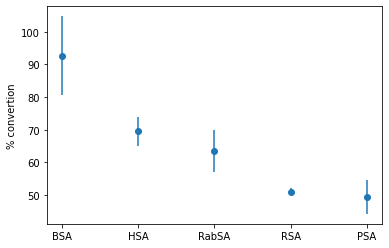

In [2]:
import matplotlib.pyplot as plt

plt.errorbar(df_mean.index, df_mean, yerr=df_std, xerr=None, fmt='o')
plt.ylabel('% convertion', fontdict=None, labelpad=None,loc=None)
plt.savefig('/media/leandro/Volumen1TB/Lean/Albumina/%alb_convertion.png')

In [9]:
cambios_fq = pd.read_csv('/media/leandro/Volumen1TB/Lean/Albumina/cambios_fq_completos.csv', sep= ' ')

In [10]:
cambios_fq.loc()

,Basic-Basic,Basic-Acid,Basic-Non_polar,Basic-Polar_uncharged,Acid-Acid,Acid-Basic,Acid-Non_polar,Acid-Polar_uncharged,Non_polar-Non_polar,Non_polar-Basic,Non_polar-Acid,Non_polar-Polar_uncharged,Polar_uncharged-Polar_uncharged,Polar_uncharged-Basic,Polar_uncharged-Acid,Polar_uncharged-Non_polar
0,0,0,0,0,0,0,0,0,93,0,0,0,0,0,0,0
1,92,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,91,0,0,2,0,0,0,0
3,0,0,0,0,0,0,0,0,93,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,91,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,0,0,0,0,0,0,0,0,26,1,0,1,54,2,1,8
602,0,0,0,0,0,0,0,0,13,0,0,1,73,0,0,6
603,11,0,0,2,0,0,0,0,0,0,0,0,73,3,1,3
604,0,0,0,0,2,0,0,0,81,0,2,4,4,0,0,0
